In [9]:
import numpy as np
import pandas as pd
import glob

# ===============================================
# A) VERİ YÜKLEME VE HAZIRLAMA (YENİ ÖZELLİKLERLE)
# ===============================================

path = '../datas/' # Lütfen yerel path'inizin doğru olduğundan emin olun!

# 1. Dosya Listelerini Oluşturma (Zamana Göre Ayrım)
training_years = [str(y) for y in range(1968, 2022)] # 1968-2021
validation_years = [str(y) for y in range(2022, 2024)] # 2022-2023
test_file = path + "atp_matches_2024.csv" 

training_files = [path + f"atp_matches_{y}.csv" for y in training_years]
validation_files = [path + f"atp_matches_{y}.csv" for y in validation_years]

# 2. Veri Yükleme Fonksiyonu
def load_and_concatenate(file_list):
    li = []
    for filename in file_list:
        try:
            # ÖNEMLİ: Sadece gerekli sütunları yükleyerek hafızayı verimli kullan
            # (winner_name, score vb. gereksiz sütunları baştan atar)
            df_temp = pd.read_csv(filename, index_col=None, header=0, usecols=RAW_FEATURES)
            li.append(df_temp)
        except Exception as e:
            # print(f"Uyarı: {filename} yüklenemedi veya sütunlar eksik. Hata: {e}")
            continue
    if li:
        return pd.concat(li, axis=0, ignore_index=True)
    return pd.DataFrame() 

# 3. KULLANILACAK HAM SÜTUNLAR (GÜNCELLENDİ)
# Modelin ihtiyaç duyduğu tüm ham veriler
RAW_FEATURES = [
    'winner_id', 'loser_id', 
    'winner_rank_points', 'loser_rank_points', 
    'winner_age', 'loser_age', 
    'winner_ht', 'loser_ht',
    'surface',          # YENİ EKLENDİ (Maç zemini)
    'winner_hand',      # YENİ EKLENDİ (Oyuncu eli)
    'loser_hand'        # YENİ EKLENDİ (Oyuncu eli)
]

# 4. MODELİN GÖRECEĞİ NİHAİ ÖZELLİKLER (Dinamikleşti)
# Bu liste artık global değil, veri işleme sırasında (6.5 bölümü) oluşturulacak.


# 5. KRİTİK FONKSİYON: ANONİMLEŞTİRME (Yeniden Düzenlendi)
def create_anonymous_dataframe(df):
    """
    Bu fonksiyon, ham veri setini alır, eksik verileri atar, 
    p1/p2 ataması yapar ve yarı işlenmiş bir DataFrame döndürür.
    One-hot encoding bu aşamada YAPILMAZ.
    """
    
    # 1. Sadece gerekli ham sütunları tut ve EKSİK VERİLERİ AT
    # (Eğer 'surface', 'ht' veya 'hand' bilgisi yoksa o maçı kullanamayız)
    df_clean = df[RAW_FEATURES].copy().dropna(subset=RAW_FEATURES)
    
    # 2. p1 ve p2'yi rastgele ata (Ezberlemeyi Önler)
    df_clean['p1_id'] = np.where(np.random.rand(len(df_clean)) > 0.5, df_clean['winner_id'], df_clean['loser_id'])
    df_clean['p2_id'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['loser_id'], df_clean['winner_id'])

    # 3. Anonim İstatistikleri Oluşturma (p1/p2)
    
    # Rank Points
    df_clean['p1_rank_points'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['winner_rank_points'], df_clean['loser_rank_points'])
    df_clean['p2_rank_points'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['loser_rank_points'], df_clean['winner_rank_points'])
    
    # Age
    df_clean['p1_age'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['winner_age'], df_clean['loser_age'])
    df_clean['p2_age'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['loser_age'], df_clean['winner_age'])
    
    # Height (Boy)
    df_clean['p1_ht'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['winner_ht'], df_clean['loser_ht'])
    df_clean['p2_ht'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['loser_ht'], df_clean['winner_ht'])
    
    # Hand (El) - YENİ EKLENDİ (Henüz 1/0 değil, 'R'/'L'/'U' olarak)
    df_clean['p1_hand'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['winner_hand'], df_clean['loser_hand'])
    df_clean['p2_hand'] = np.where(df_clean['p1_id'] == df_clean['winner_id'], df_clean['loser_hand'], df_clean['winner_hand'])

    # Surface (Zemin) - Bu özellik maça aittir, p1/p2'ye değil, o yüzden olduğu gibi kalır.
    # 'surface' sütunu zaten df_clean içinde mevcut.

    # 4. Etiket (Y) oluşturma: p1_wins = 1 (p1 kazandıysa), 0 (p2 kazandıysa)
    Y_df = (df_clean['winner_id'] == df_clean['p1_id']).astype(int)
    
    # 5. Sonraki adıma (one-hot encoding) hazır özellikleri seç
    features_to_process = [
        'p1_rank_points', 'p2_rank_points', 
        'p1_age', 'p2_age', 
        'p1_ht', 'p2_ht',
        'p1_hand', 'p2_hand',   # Kategorik
        'surface'               # Kategorik
    ]
    
    X_df = df_clean[features_to_process]
    
    return X_df, Y_df


# 6. Veri Kümelerini Yükleme ve Anonimleştirme
print("Ham veri dosyaları yükleniyor...")
df_train_full = load_and_concatenate(training_files)
df_val_full = load_and_concatenate(validation_files)
try:
    df_test = pd.read_csv(test_file, usecols=RAW_FEATURES)
except:
    df_test = pd.DataFrame()

print("Veri anonimleştiriliyor...")
X_train_df, Y_train_df = create_anonymous_dataframe(df_train_full)
X_val_df, Y_val_df = create_anonymous_dataframe(df_val_full)
X_test_df, Y_test_df = create_anonymous_dataframe(df_test) # Düzeltme: df_test olmalı

# Y etiketlerini Numpy formatına çevir
Y_train = Y_train_df.values.reshape(1, -1)
Y_val = Y_val_df.values.reshape(1, -1)
Y_test = Y_test_df.values.reshape(1, -1)


# 6.5 (YENİ BÖLÜM) ÖZELLİK MÜHENDİSLİĞİ (ONE-HOT ENCODING VE HİZALAMA)
# Train, Val ve Test setlerindeki kategorilerin (örn. surface)
# tutarlı olmasını sağlamak için hepsini birleştir, işlemi yap, ayır.

print("Özellik mühendisliği (One-Hot Encoding) yapılıyor...")

# Veri setlerini tanıyabilmek için etiketle
X_train_df['dataset'] = 'train'
X_val_df['dataset'] = 'val'
X_test_df['dataset'] = 'test'

# Tüm X verilerini birleştir
df_combined = pd.concat([X_train_df, X_val_df, X_test_df], axis=0, ignore_index=True)

# --- Kategorik Özellik İşleme ---

# 1. Hand (El) İşleme
# 'U' (Bilinmeyen) ve NaNs (Eksik) olanları en yaygın olan 'R' (Sağ) ile doldur
df_combined['p1_hand'] = df_combined['p1_hand'].replace('U', 'R').fillna('R')
df_combined['p2_hand'] = df_combined['p2_hand'].replace('U', 'R').fillna('R')

# 'L' (Solak) olup olmadığını 1/0 olarak kodla
df_combined['p1_is_L'] = (df_combined['p1_hand'] == 'L').astype(int)
df_combined['p2_is_L'] = (df_combined['p2_hand'] == 'L').astype(int)

# 2. Surface (Zemin) İşleme
# 'Carpet' (Halı) çok nadirdir, 'Hard' (Sert) zemin gibi kabul edilebilir veya 'U' (Bilinmeyen)
df_combined['surface'] = df_combined['surface'].replace('Carpet', 'Hard').fillna('U')

# One-Hot Encoding: 'surface' sütununu 'surface_Hard', 'surface_Clay' vb. sütunlara ayır.
df_combined = pd.get_dummies(df_combined, columns=['surface'], prefix='surface')


# --- NİHAİ ÖZELLİK LİSTESİNİ OLUŞTURMA ---
# Sayısal (Base) Özellikler
base_features = [
    'p1_rank_points', 'p2_rank_points', 
    'p1_age', 'p2_age', 
    'p1_ht', 'p2_ht'
]

# Yeni oluşturulan özellikler
hand_features = ['p1_is_L', 'p2_is_L']
surface_features = [col for col in df_combined.columns if col.startswith('surface_') and col != 'surface_U']
# Not: surface_U'yu (Bilinmeyen zemin) atıyoruz, çünkü 3 zemin türü de 0 ise, 
# model zaten 'U' olduğunu anlayacaktır (dummy variable trap).

FINAL_FEATURES = base_features + hand_features + surface_features

# 3. Sayısal Verilerde Eksik Veri Doldurma (Imputation)
# (Çok nadir de olsa, rank_points vb. eksikse, ortalama ile doldur)
df_combined[base_features] = df_combined[base_features].fillna(df_combined[base_features].mean())

# --- Veri Setlerini Geri Ayırma ---
df_train_final = df_combined[df_combined['dataset'] == 'train'][FINAL_FEATURES]
df_val_final = df_combined[df_combined['dataset'] == 'val'][FINAL_FEATURES]
df_test_final = df_combined[df_combined['dataset'] == 'test'][FINAL_FEATURES]


# 7. Normalleştirme ve Numpy Dönüşümü
print("Veri normalize ediliyor...")

# Numpy formatına dönüştür (N_X, m)
X_train_np = df_train_final.T.values.astype(np.float64)
X_val_np = df_val_final.T.values.astype(np.float64)
X_test_np = df_test_final.T.values.astype(np.float64)

# Normalleştirme (Sadece Eğitim setinin max değerlerine göre)
X_max_per_feature = np.max(X_train_np, axis=1, keepdims=True)

# 0'a bölme hatasını engelle
X_max_per_feature[X_max_per_feature == 0] = 1.0

X_train = X_train_np / X_max_per_feature
X_val = X_val_np / X_max_per_feature
X_test = X_test_np / X_max_per_feature

# 8. Ana Eğitim Değişkenlerini Güncelleme
X = X_train
Y = Y_train

# Kontrol
print(f"--- Yeni Veri Yapısı (Anonimleştirilmiş ve Genişletilmiş) ---")
print(f"Özellik İsimleri: {FINAL_FEATURES}")
print(f"1. Eğitim Seti Boyutu: {X_train.shape[1]} örnek")
print(f"2. Doğruluk Seti Boyutu: {X_val.shape[1]} örnek")
print(f"3. Test Seti Boyutu: {X_test.shape[1]} örnek")

Ham veri dosyaları yükleniyor...
Veri anonimleştiriliyor...
Özellik mühendisliği (One-Hot Encoding) yapılıyor...
Veri normalize ediliyor...
--- Yeni Veri Yapısı (Anonimleştirilmiş ve Genişletilmiş) ---
Özellik İsimleri: ['p1_rank_points', 'p2_rank_points', 'p1_age', 'p2_age', 'p1_ht', 'p2_ht', 'p1_is_L', 'p2_is_L', 'surface_Clay', 'surface_Grass', 'surface_Hard']
1. Eğitim Seti Boyutu: 96910 örnek
2. Doğruluk Seti Boyutu: 5779 örnek
3. Test Seti Boyutu: 3000 örnek


In [10]:
# ===============================================
# YAPILANDIRMA: HİPER-PARAMETRELER (AYARLANABİLİR KISIM)
# ===============================================
N_X = X.shape[0]        # Girdi Boyutu
N_H1 = 64               # 1. Gizli Katman Nöron Sayısı
N_H2 = 32               # 2. Gizli Katman Nöron Sayısı
N_Y = Y.shape[0]        # Çıktı Boyutu
LEARNING_RATE = 0.05    # Öğrenme Hızı (DENEME İÇİN DEĞİŞTİRİLEBİLİR!)
EPOCHS = 5000           # Eğitim Döngüsü Sayısı
PATIENCE = 3            # YENİ EKLENDİ: Kaç kontrol noktası boyunca sabredeceği

print(f"Girdi Özellik Sayısı (N_X): {N_X}")

Girdi Özellik Sayısı (N_X): 11


In [11]:
# ===============================================
# A) YARDIMCI FONKSİYONLAR (HELPER FUNCTIONS)
# ===============================================

def sigmoid(Z):
    """Sigmoid aktivasyon fonksiyonunu hesaplar. Çıktıyı 0 ile 1 arasına sıkıştırır."""
    A = 1 / (1 + np.exp(-Z))
    return A

def sigmoid_backward(A):
    """Sigmoid'in türevini (Geriye yayılım için) hesaplar: A * (1 - A)"""
    # Bu türev, hatanın gizli katmandan geriye doğru nasıl yayılacağını belirler.
    dZ = A * (1 - A) 
    return dZ

# ===============================================
# B) MODEL SINIFI VE BAŞLATMA
# ===============================================

def initialize_parameters(n_x, n_h1, n_h2, n_y):
    """
    Ağırlık ve sapmaları 2 gizli katmanlı (3 katmanlı ağ) için başlatır.
    (Girdi -> H1 -> H2 -> Çıktı)
    Xavier/Glorot başlatma yöntemi kullanır.
    """
    
    # Katman 1 (Girdi -> H1)
    W1 = np.random.randn(n_h1, n_x) * np.sqrt(1 / n_x)
    b1 = np.zeros((n_h1, 1))
    
    # Katman 2 (H1 -> H2)
    W2 = np.random.randn(n_h2, n_h1) * np.sqrt(1 / n_h1)
    b2 = np.zeros((n_h2, 1))
    
    # Katman 3 (H2 -> Çıktı)
    W3 = np.random.randn(n_y, n_h2) * np.sqrt(1 / n_h2)
    b3 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, 
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}
    return parameters


def forward_propagation(X, parameters):
    """Girdiyi (X) alır ve 3 katmanlı ağda nihai tahmini (A3) hesaplar."""
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # 1. Katman (Gizli Katman 1)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) # Aktivasyon: tanh
    
    # 2. Katman (Gizli Katman 2)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2) # Aktivasyon: tanh
    
    # 3. Katman (Çıkış Katmanı)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3) # Aktivasyon: sigmoid (0-1 arası olasılık için)
    
    cache = {"Z1": Z1, "A1": A1, 
             "Z2": Z2, "A2": A2, 
             "Z3": Z3, "A3": A3}
    return A3, cache # Nihai tahmin A3'tür

# D) MALİYET FONKSİYONU (GÜNCELLENDİ)
def compute_cost(A3, Y): # A2 yerine A3 (Nihai Tahmin)
    """
    İkili Çapraz Entropi maliyetini hesaplar.
    
    A3: Ağın nihai tahmini (Y_hat)
    Y: Gerçek Etiketler
    """
    m = Y.shape[1] # Örnek sayısı
    
    # np.log(0) hatasını önlemek için kırpma (clipping)
    epsilon = 1e-8 
    A3_clipped = np.clip(A3, epsilon, 1 - epsilon)
    
    # Çapraz Entropi formülü
    log_probs = Y * np.log(A3_clipped)
    log_probs_complement = (1 - Y) * np.log(1 - A3_clipped)
    
    cost = - (1 / m) * (np.sum(log_probs + log_probs_complement))
    
    cost = np.squeeze(cost) 
    
    return cost

# E) GERİYE YAYILIM (BACKWARD PROPAGATION) (2 KATMAN İÇİN GÜNCELLENDİ)
def backward_propagation(parameters, cache, X, Y):
    
    # 1. Gerekli Değişkenleri Çekme
    m = X.shape[1] # Örnek sayısı
    
    # Parametreler (Ağırlıklar)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    # Cache (Aktivasyonlar)
    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    
    # 2. Çıkış Katmanı Gradyanları (Layer 3)
    dZ3 = A3 - Y # (Cross-entropy ve Sigmoid'in birleşik türevi)
    dW3 = (1 / m) * np.dot(dZ3, A2.T)
    db3 = np.mean(dZ3, axis=1, keepdims=True)
    
    # 3. Gizli Katman Gradyanları (Layer 2)
    dZ2_weighted = np.dot(W3.T, dZ3)
    dZ2 = dZ2_weighted * (1 - np.power(A2, 2)) # (tanh türevi)
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    
    # 4. Gizli Katman Gradyanları (Layer 1)
    dZ1_weighted = np.dot(W2.T, dZ2)
    dZ1 = dZ1_weighted * (1 - np.power(A1, 2)) # (tanh türevi)
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    # Gradyanları bir sözlükte toplama
    grads = {"dW1": dW1, "db1": db1, 
             "dW2": dW2, "db2": db2,
             "dW3": dW3, "db3": db3}
    
    return grads

# F) PARAMETRE GÜNCELLEME (GRADIENT DESCENT) (GÜNCELLENDİ)
def update_parameters(parameters, grads, learning_rate):
    
    # Parametreleri al
    W1 = parameters["W1"]; b1 = parameters["b1"]
    W2 = parameters["W2"]; b2 = parameters["b2"]
    W3 = parameters["W3"]; b3 = parameters["b3"]
    
    # Gradyanları al
    dW1 = grads["dW1"]; db1 = grads["db1"]
    dW2 = grads["dW2"]; db2 = grads["db2"]
    dW3 = grads["dW3"]; db3 = grads["db3"]
    
    # Gradyan İnişi Kuralını Uygulama
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    
    # Güncellenmiş parametreleri sözlüğe kaydetme
    parameters = {"W1": W1, "b1": b1, 
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}
    
    return parameters

# G) ANA EĞİTİM FONKSİYONU (GÜNCELLENDİ: ERKEN DURDURMA EKLENDİ)
def train_ann(X, Y, X_val, Y_val, n_h1, n_h2, learning_rate, num_epochs, print_cost=False, patience=3):
    
    n_x = X.shape[0] # Girdi boyutu
    n_y = Y.shape[0] # Çıktı boyutu
    
    # 1. PARAMETRELERİ BAŞLATMA
    parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)
    
    costs = []
    validation_costs = [] 
    
    # --- Erken Durdurma Değişkenleri ---
    best_val_cost = np.inf
    patience_counter = 0
    best_parameters = {}
    best_epoch = 0
    print_interval = EPOCHS / 10 if (EPOCHS / 10) >= 1 else 1 # Yazdırma aralığı
    # ------------------------------------
    
    # 2. EĞİTİM DÖNGÜSÜ
    for i in range(num_epochs):
        
        # 1. İLERİ YAYILIM (Training Set)
        A3, cache = forward_propagation(X, parameters)
        
        # 2. MALİYET HESAPLAMA (Training Cost)
        cost = compute_cost(A3, Y)
        
        # 3. GERİYE YAYILIM
        grads = backward_propagation(parameters, cache, X, Y)
        
        # 4. PARAMETRE GÜNCELLEME
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # 5. DOĞRULAMA MALİYETİ HESAPLAMA (Her epoch'ta değil, sadece kontrol noktasında)
        # (Döngüyü hızlandırmak için kontrolü yazdırma aralığına taşıyabiliriz)
        
        # Maliyet takibi ve yazdırma
        if i % print_interval == 0:
            
            # Doğrulama setini sadece şimdi kontrol et (Hız kazanımı)
            A3_val, _ = forward_propagation(X_val, parameters) 
            cost_val = compute_cost(A3_val, Y_val)
            
            costs.append(cost)
            validation_costs.append(cost_val)
            
            if print_cost:
                train_confidence = np.exp(-cost) * 100
                val_confidence = np.exp(-cost_val) * 100
                print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f} (Güven: %{train_confidence:.2f}) | DOĞRULAMA Maliyeti: {cost_val:.4f} (Güven: %{val_confidence:.2f})")
            
            # --- ERKEN DURDURMA KONTROLÜ ---
            if cost_val < best_val_cost:
                # İyileşme var
                best_val_cost = cost_val
                best_parameters = parameters.copy() # En iyi parametreleri kopyala
                best_epoch = i
                patience_counter = 0 # Sabrı sıfırla
                if print_cost:
                    print(f"          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)")
            else:
                # İyileşme yok
                patience_counter += 1
                if print_cost:
                    print(f"          -> (Sabır: {patience_counter}/{patience})")
            
            # Sabır taştı mı?
            if patience_counter >= patience:
                print(f"\n--- ERKEN DURDURMA TETİKLENDİ ---")
                print(f"Model, {patience} kontrol noktası ({int(patience * print_interval)} epoch) boyunca iyileşme göstermedi.")
                print(f"Eğitim durduruldu. En iyi epoch: {best_epoch} (Maliyet: {best_val_cost:.4f})")
                break # Eğitim döngüsünü sonlandır
            # ---------------------------------
                
    # Döngü bittiğinde (ya da erken durduğunda)
    # Artık son epoch'taki değil, KAYDEDİLEN EN İYİ parametreleri döndür
    
    # Not: Döngü sonrası son maliyeti ekleme bloğu kaldırıldı,
    # çünkü en iyi model muhtemelen son model değil.
    
    # Eğer döngü hiç iyileşme bulamazsa (çok düşük epoch'ta biterse)
    if not best_parameters:
        best_parameters = parameters
    
    return best_parameters, costs, validation_costs

In [12]:
# H) EĞİTİMİ BAŞLATMA VE SONUÇLARI GÖRSELLEŞTİRME

print(f"--- Yapay Sinir Ağı Eğitimi Başlatılıyor ---")
# GÜNCELLENDİ: N_H1 ve N_H2'yi yazdırmak için
print(f"Girdi Boyutu (N_X): {N_X} | Katman 1 (N_H1): {N_H1} | Katman 2 (N_H2): {N_H2} | Örnek Sayısı (m): {X.shape[1]}")
print(f"Öğrenme Hızı: {LEARNING_RATE} | Epoch Sayısı: {EPOCHS} | Sabır: {PATIENCE}") # Güncellendi

# Modelin Eğitilmesi (!!! ÇAĞRI GÜNCELLENDİ !!!)
optimized_parameters, costs, validation_costs = train_ann( 
    X=X_train, 
    Y=Y_train, 
    X_val=X_val, 
    Y_val=Y_val, 
    n_h1=N_H1, # n_h yerine n_h1
    n_h2=N_H2, # YENİ ARGÜMAN
    learning_rate=LEARNING_RATE, 
    num_epochs=EPOCHS, 
    print_cost=True,
    patience=PATIENCE # YENİ ARGÜMAN EKLENDİ
)
# Modelin Eğitilmesi (!!! EĞİTİM BU SATIRDA BAŞLIYOR !!!)
optimized_parameters, costs, validation_costs = train_ann( 
    X=X_train, 
    Y=Y_train, 
    X_val=X_val, 
    Y_val=Y_val, 
    n_h1=N_H1, # n_h yerine n_h1
    n_h2=N_H2, # YENİ ARGÜMAN
    learning_rate=LEARNING_RATE, 
    num_epochs=EPOCHS, 
    print_cost=True
)

print(f"\n--- Eğitim Tamamlandı ---")
print(f"Başlangıç EĞİTİM Maliyeti: {costs[0]:.4f}")
print(f"Nihai EĞİTİM Maliyeti (Epoch {EPOCHS}): {costs[-1]:.4f}")
print(f"Nihai DOĞRULAMA Maliyeti: {validation_costs[-1]:.4f}") # Doğrulama sonucunu da yazdırıyoruz

# Sonuçları Görselleştirme
epochs_list = np.arange(0, EPOCHS + 1, (EPOCHS / 10)) # X ekseni (0, 1000, 2000, ...) hazırlanır.


--- Yapay Sinir Ağı Eğitimi Başlatılıyor ---
Girdi Boyutu (N_X): 11 | Katman 1 (N_H1): 64 | Katman 2 (N_H2): 32 | Örnek Sayısı (m): 96910
Öğrenme Hızı: 0.05 | Epoch Sayısı: 5000 | Sabır: 3


Epoch 0 | EĞİTİM Maliyeti: 0.6983 (Güven: %49.74) | DOĞRULAMA Maliyeti: 0.6993 (Güven: %49.69)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 500 | EĞİTİM Maliyeti: 0.6810 (Güven: %50.61) | DOĞRULAMA Maliyeti: 0.6779 (Güven: %50.77)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 1000 | EĞİTİM Maliyeti: 0.6631 (Güven: %51.53) | DOĞRULAMA Maliyeti: 0.6577 (Güven: %51.81)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 1500 | EĞİTİM Maliyeti: 0.6470 (Güven: %52.36) | DOĞRULAMA Maliyeti: 0.6434 (Güven: %52.55)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 2000 | EĞİTİM Maliyeti: 0.6386 (Güven: %52.80) | DOĞRULAMA Maliyeti: 0.6401 (Güven: %52.72)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 2500 | EĞİTİM Maliyeti: 0.6355 (Güven: %52.97) | DOĞRULAMA Maliyeti: 0.6415 (Güven: %52.65)
          -> (Sabır: 1/3)
Epoch 3000 | EĞİTİM Maliyeti: 0.6345 (Güven: %53.02) | DOĞRULAMA Maliyeti: 

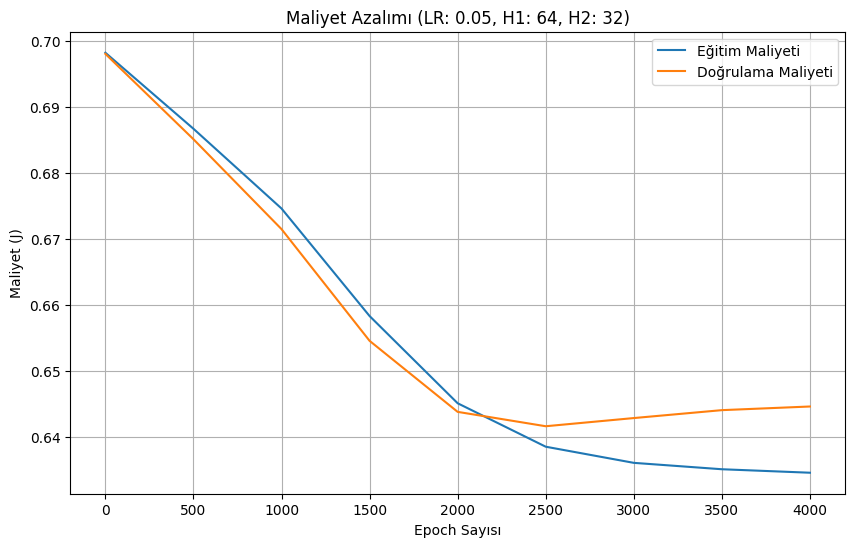

In [14]:
# Sonuçları Görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# --- DÜZELTME: X EKSENİNİ DİNAMİK OLARAK OLUŞTURMA ---
# 'costs' listesi kaç elemanlıysa (örn: 10), o kadar nokta oluştur.
# (print_interval'ı train_ann fonksiyonunuzdaki gibi hesaplıyoruz)
print_interval = EPOCHS / 10 if (EPOCHS / 10) >= 1 else 1

# epochs_list = [0, 1000, 2000, ..., 9000] (len(costs) == 10 ise)
# (Eğer Erken Durdurma 3000'de durursa, len(costs)=4 olur ve liste [0, 1000, 2000, 3000] olur)
epochs_list_actual = np.arange(0, len(costs)) * print_interval
# ----------------------------------------------------

# Eğitim Maliyeti
# Hata veren satır: plt.plot(epochs_list, costs, label="Eğitim Maliyeti")
plt.plot(epochs_list_actual, costs, label="Eğitim Maliyeti")

# Doğrulama Maliyeti
# (validation_costs listesinin uzunluğu daima costs listesiyle aynı olacaktır)
plt.plot(epochs_list_actual, validation_costs, label="Doğrulama Maliyeti")

# plt.title'daki N_H, 2 katmanlı mimaride N_H1 ve N_H2 olmalıdır
# Eğer 1 katmanlı mimarideyseniz 'N_H' doğrudur.
# 2 katmanlı için:
try:
    plt.title(f"Maliyet Azalımı (LR: {LEARNING_RATE}, H1: {N_H1}, H2: {N_H2})")
except NameError:
    # 1 katmanlı için:
    plt.title(f"Maliyet Azalımı (LR: {LEARNING_RATE}, N_H: {N_H})")

plt.xlabel("Epoch Sayısı")
plt.ylabel("Maliyet (J)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# J) DOĞRULUK HESAPLAMA FONKSİYONU
def evaluate_accuracy(Y_prediction, Y_true):
    """
    Tahminleri (Y_prediction) gerçek etiketlerle (Y_true) karşılaştırarak
    modelin doğruluk skorunu hesaplar.
    """
    # NumPy'da iki matrisi karşılaştırmak için == kullanılır. 
    # Sonuç (True=1, False=0) matrisidir.
    correct_predictions = (Y_prediction == Y_true)
    
    # Ortalama almak, bize doğrudan doğru tahminlerin oranını (Doğruluğu) verir.
    accuracy = np.mean(correct_predictions) 
    
    return accuracy


# I) TAHMİN FONKSİYONU
def predict(parameters, X):
    """
    Eğitilmiş parametreleri kullanarak girdi X için tahmin yapar.
    
    Argümanlar:
    parameters -- Eğitilmiş W ve b parametreleri sözlüğü
    X -- Tahmin edilecek girdi matrisi (N, m)
    
    Döndürür:
    Y_prediction -- Girdi X için 0 veya 1 etiketlerinden oluşan NumPy vektörü
    """
    
    # Sadece İleri Yayılım yapıyoruz
    A2, cache = forward_propagation(X, parameters)
    
    # Karar Eşiği (Threshold): Olasılık 0.5'ten büyükse 1 (kazandı), değilse 0 (kaybetti).
    Y_prediction = (A2 > 0.5).astype(int)
    
    return Y_prediction

In [ ]:
# K) NİHAİ PERFORMANS VE SONUÇ BLOĞU

# 1. Test Seti Tahmini (2024 verisi)
# optimized_parameters: train_ann'den gelen eğitilmiş W ve b değerleri
Y_pred_test = predict(optimized_parameters, X_test)

# 2. Doğruluk Hesaplama
# Modelin 2024 verisindeki nihai performansı
test_accuracy = evaluate_accuracy(Y_pred_test, Y_test)

print(f"\n--- Model Değerlendirmesi ---")
print(f"Eğitim Seti (1968-2021) Örnek Sayısı: {X.shape[1]}")
print(f"Doğrulama Seti (2022-2023) Örnek Sayısı: {X_val.shape[1]}")
print(f"Test Seti (2024) Örnek Sayısı: {X_test.shape[1]}")
print("-" * 35)
print(f"Nihai TEST Doğruluğu (2024): {test_accuracy*100:.2f}%")
print("-" * 35)


--- Model Değerlendirmesi ---
Eğitim Seti (1968-2021) Örnek Sayısı: 96910
Doğrulama Seti (2022-2023) Örnek Sayısı: 5779
Test Seti (2024) Örnek Sayısı: 3000
-----------------------------------
Nihai TEST Doğruluğu (2024): 63.17%
-----------------------------------
